## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.sats2backtest as s2b
import src.timeutils as tu

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169703, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [6]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


[0.3666278799797873,
 0.36669989939134046,
 0.366681143387826,
 0.3669507381762064,
 0.36680105434233357,
 0.3651792973782567,
 0.3657543600879529,
 0.3654636420334786,
 0.3659557595043317,
 0.3660145768745761]

## Train CNN-LSTM model using full or part of data set

In [7]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.90)
btc_model.sats2model()

In [8]:
datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')

'220625_16_46'

In [9]:
MODELDATE_TO_SAVE = datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')
PRESAVED_MODELDATE = "220624_16_16"

if PRESAVED_MODELDATE == MODELDATE_TO_SAVE :
  model_name = f"model/LSTM_CNN_pretrained_{MODELDATE_TO_SAVE}"
else:
  model_name = "model/LSTM_CNN_model"

btc_model.sats2train(model_name, save_model = False, epochs=20)

Epoch 1/20
11/11 [==============================] - 21s 524ms/step - loss: 0.2052 - val_loss: 0.1471
Epoch 2/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0552 - val_loss: 0.0792
Epoch 3/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0373 - val_loss: 0.0675
Epoch 4/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0200 - val_loss: 0.0205
Epoch 5/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0189 - val_loss: 0.0225
Epoch 6/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0368 - val_loss: 0.0650
Epoch 7/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0326 - val_loss: 0.0459
Epoch 8/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0187 - val_loss: 0.0205
Epoch 9/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0200 - val_loss: 0.0285
Epoch 10/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0326 - val_loss: 0.0153
Ep

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


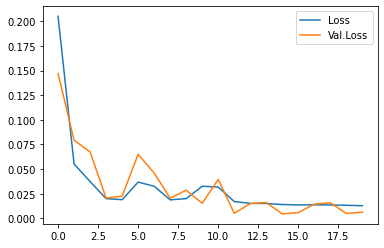

In [10]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Retrain for longer

In [11]:
btc_model.sats2train(model_name, save_model = True, epochs=100)

Epoch 1/100
11/11 [==============================] - 1s 106ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 2/100
11/11 [==============================] - 1s 105ms/step - loss: 0.0124 - val_loss: 0.0169
Epoch 3/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0130 - val_loss: 0.0073
Epoch 4/100
11/11 [==============================] - 1s 100ms/step - loss: 0.0123 - val_loss: 0.0050
Epoch 5/100
11/11 [==============================] - 1s 101ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 6/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0125 - val_loss: 0.0113
Epoch 7/100
11/11 [==============================] - 1s 103ms/step - loss: 0.0117 - val_loss: 0.0047
Epoch 8/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0121 - val_loss: 0.0063
Epoch 9/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 10/100
11/11 [==============================] - 1s 102ms/step - loss: 0.0116 - val_loss: 

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


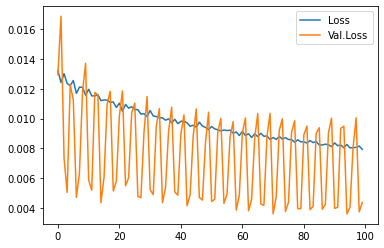

In [12]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [13]:
btc_model.sats2pred()

In [14]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(btc_model.scaler, ts_btc.candles, btc_model.preds)

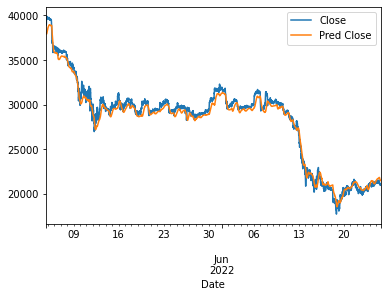

In [15]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 0)
df_preds_true.dropna().plot()

## Test on pretrained model

In [16]:
USE_PRETRAINED = False

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.90)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = True)
loaded_model.preds

array([[0.5202888 ],
       [0.52031666],
       [0.520142  ],
       ...,
       [0.37027496],
       [0.37006307],
       [0.36992228]], dtype=float32)

In [17]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(loaded_model.scaler, ts_btc.candles, loaded_model.preds)

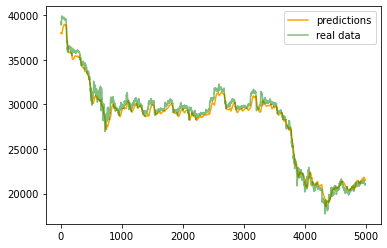

In [18]:
plt.plot(preds, color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point+ts_btc.step_back:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

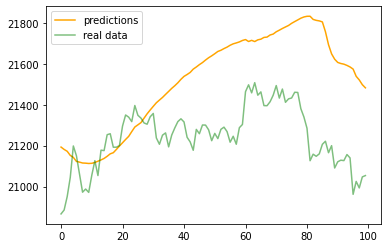

In [19]:
plt.plot(preds[-100:], color='orange', label='predictions')
plt.plot(true_vals[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

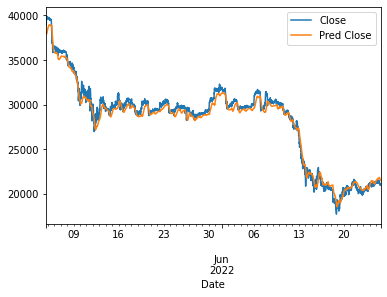

In [57]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

In [58]:
df_preds_true.dropna()

,Close,Pred Close
Date,,
2022-05-04 16:16:00,39316.87,37997.802087
2022-05-04 16:31:00,39198.96,38000.859287
2022-05-04 16:46:00,39189.99,37981.678137
2022-05-04 17:01:00,38953.44,37991.380002
2022-05-04 17:16:00,38956.10,37992.852957
...,...,...
2022-06-25 15:46:00,20961.89,21584.986376
2022-06-25 16:01:00,21025.05,21574.512028
2022-06-25 16:16:00,20993.12,21539.151283


In [59]:
np.array(true_vals[btc_model.split_point+ts_btc.step_back+1:])

array([39316.87, 39198.96, 39189.99, ..., 20993.12, 21047.17, 21053.63])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Fee: 0.025
----------------------
Buy      335 ( 195 ok 140 ko )
Avg PCT gain: 1.0058901784451884
Avg PCT loss: 0.9955794436003375
Wins  PCT   0.582089552238806
Avg PCT Gain.    1.0058901784451884
No-op    0
Wallet   10813.784999999987
Drawback -927.1227499999984
Kelly Fraction    0.16846283634824116
Total earned 10813.784999999987


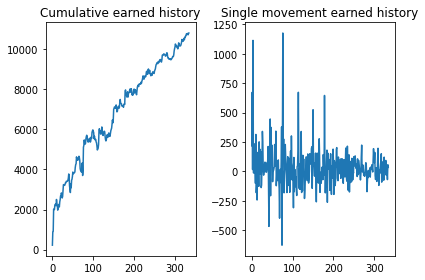

In [60]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)

Fee: 0.025
----------------------
Buy      335 ( 195 ok 140 ko )
Wallet   10813.784999999996
Drawback -927.1227499999984
Total earned 10813.784999999996


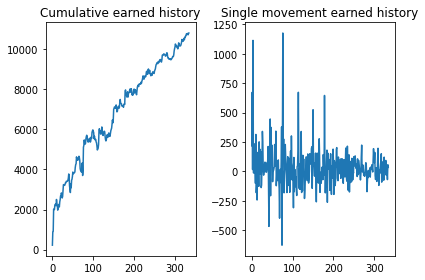

In [61]:
total_wallet_history, single_wallet_history, wallet = s2b.backtest_debug(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)